In [76]:
from core.ner.spacy import get_transformer_nlp

In [77]:
example_description = """
Liposomal Encapsulation of Existing Cancer Drugs

Many existing chemotherapeutic drugs used to treat cancer have poor solubility, low bioavailability, and high systemic toxicity. A novel drug reformulation strategy is proposed to encapsulate these drugs within liposomes to improve their pharmacokinetic profile and therapeutic index.

Liposomes are spherical lipid vesicles consisting of one or more bilayers surrounding an aqueous core. Their hydrophobic membrane and aqueous inner cavity allow them to carry both lipophilic and hydrophilic drug compounds. Liposomes can protect encapsulated drugs from degradation, reduce interactions with blood components, and alter drug distribution in the body.

In this approach, liposomes composed of phospholipids like phosphatidylcholine will be prepared. The antineoplastic agent will be dissolved in an organic solvent and added to the liposome solution, becoming integrated into the lipid bilayer. An active loading method can also be used in which a gradient is created to load the drug into the liposome interior.

The liposomal encapsulation aims to increase the circulation time of the drug in the bloodstream by evading rapid renal clearance and degradation. It will also facilitate preferential accumulation of the drug at the tumor site due to the enhanced permeability and retention effect. The liposomes will hopefully minimize exposure of healthy tissues, improving the therapeutic index.

In vivo studies in animal models will evaluate the pharmacokinetics, biodistribution, toxicity, and efficacy of the liposomal formulation compared to the free drug. If successful, this novel reformulation approach could significantly improve the clinical utility of existing antineoplastic agents.
"""

In [78]:
doc = get_transformer_nlp()(example_description)

In [103]:
from clients.low_level.postgres import PsqlDatabaseClient

db = PsqlDatabaseClient("patents")
SIMILARITY_EXAGGERATION_FACTOR = 100
DEFAULT_K = 1000

k = DEFAULT_K
# <=> is cosine distance
results = await db.select(
      f"""
            select
                  assignee,
                  array_agg(distinct applications.publication_number) as ids,
                  count(distinct applications.title) as count,
                  array_agg(distinct applications.title) as titles,
                  array_agg(distinct term) as terms,
                  min(2024-date_part('year', priority_date))::int as min_age,
                  POW(MAX(1 - (patent_embeddings.vector <=> '{doc.vector.tolist()}')), {SIMILARITY_EXAGGERATION_FACTOR}) as max_relevance_score,
                  POW((1 - (AVG(patent_embeddings.vector) <=> '{doc.vector.tolist()}')), {SIMILARITY_EXAGGERATION_FACTOR}) as avg_relevance_score,
                  (
                        SUM(
                              POW((1 - (patent_embeddings.vector <=> '{doc.vector.tolist()}')), {SIMILARITY_EXAGGERATION_FACTOR}) -- cosine similarity
                              * POW(((date_part('year', priority_date) - 2000) / 24), 2) -- recency
                        )
                  ) as score
            from applications, biosym_annotations, unnest(assignees) assignee, patent_embeddings
            WHERE biosym_annotations.publication_number = applications.publication_number
            AND applications.publication_number = patent_embeddings.id
            AND applications.publication_number in
                  (
                        SELECT max(id)
                        FROM (
                              SELECT id
                              FROM patent_embeddings
                              ORDER BY (1 - (vector <=> '{doc.vector.tolist()}')) DESC
                              LIMIT {k}
                        ) embed, applications
                        WHERE embed.id = applications.publication_number
                        GROUP BY lower(concat(applications.title, applications.assignees[1]))
                  )
            AND assignee ~* '\y(?:inc|corp|co)\y'
            group by assignee
            order by count(*) desc
      """
)

Passed non-uri string; assuming db name. Expanding to uri.


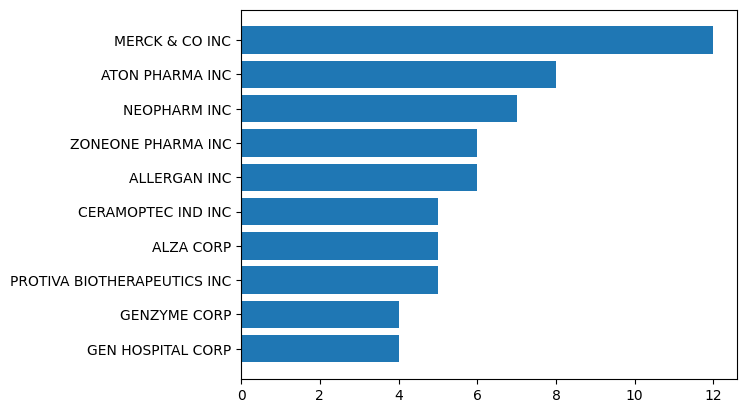

In [104]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
import polars as pl

df = pl.DataFrame(results).sort(by="count", descending=True)
assignees: list[str] = df["assignee"].to_list()[0:10]
counts = df["count"].to_list()[0:10]

ax.xaxis.get_major_locator().set_params(integer=True)
ax.barh(assignees, counts)
ax.invert_yaxis()

plt.show()



In [105]:
pdf = df.sort(by="score", descending=True).to_pandas()
pdf.style
display(pdf)
import dataframe_image as dfi
# dfi.export(pdf, 'df_styled.png')


,assignee,ids,count,titles,terms,min_age,max_relevance_score,avg_relevance_score,avg_relevance_score2,score
0,ZONEONE PHARMA INC,"[WO-2014121211-A3, WO-2014121235-A3, WO-201602...",6,[Pharmaceutical formulations of and methods to...,"[4-methylumbelliferone, chelating agent liposo...",8,0.408117,0.459660,0.992257,4.568296
1,LUNELLA BIOTECH INC,"[WO-2019108729-A1, WO-2021229499-A1]",2,[Myristoyl derivatives of 9-amino-doxycycline ...,"[9-amino-doxycycline, antibiotic resistance, c...",4,0.285363,0.351510,0.989599,4.427561
2,MERRIMACK PHARMACEUTICALS INC,"[WO-2017031442-A1, WO-2017031445-A1, WO-201716...",3,"[Combination therapy for cancer treatment, Com...","[cervical cancer, docetaxel, epha2 targeting m...",8,0.314516,0.353738,0.989662,4.290914
3,IMGT CO LTD,"[WO-2018062865-A1, WO-2022169329-A1]",2,[Composition for hepatic arterial chemoemboliz...,"[adriamycin, anticancer, better blood-brain ba...",3,0.268196,0.320875,0.988697,4.274386
4,ESCAPE THERAPEUTICS INC,[WO-2022087026-A1],1,[Enhanced skin permeation of a novel peptide v...,"[common skin, decapeptide-12, enhanced skin pe...",4,0.344868,0.344868,0.989411,3.592371
...,...,...,...,...,...,...,...,...,...,...
164,ALCON INC,[WO-03059194-A3],1,[Use of synthetic inorganic nanoparticles as c...,"[inert carriers, modify the rheological, synth...",23,0.251363,0.251363,0.986286,0.001746
165,GENTERIC INC,[WO-0152903-A1],1,[Method for nucleic acid transfection of cells],"[defective gene, endogenous gene, exogenous nu...",24,0.259729,0.259729,0.986609,0.000000
166,ORTHO MCNEIL PHARM INC,[WO-0198531-A1],1,[Resazurin-based cytotoxicity assay],"[cytotoxic compound, cytotoxic potential, hepa...",24,0.248926,0.248926,0.986190,0.000000
167,CELLGATE INC,[WO-0162297-A9],1,[Compositions and methods for enhancing drug d...,"[delivery enhancing transporter, delivery-enha...",24,0.264830,0.264830,0.986801,0.000000
